Iris Dataset


Target variable: class:  Iris Setosa, Iris Versicolour, or Iris Virginica (categorical encoded 0,1,2)


Feature variables: sepal length, sepal width, petal length, petal width (normalized to 0-1 using formula X-Xmin/ Xmax-Xmin)




Problem: use Iris dataset to discover relationships and find/compare the best algorithm for the dataset using train data then analyzing performance with test data.

Objective: find the best model that fits the target class to the features sepal length, sepal width, petal length, petal width

Gaussian Discriminant Analysis (GDA)

In [1]:
##########Train/Test##########
##Based on GDA iris example given on modules github##
##used sklearn library only for encoding target variable##
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# Def GDA func
def gaussian_pdf(X, mean, Sigma):
    X = X.reshape(-1, 1)
    mean = mean.reshape(-1, 1)
    p, _ = Sigma.shape # Initialize and reshap
    
    Sigma_inv = np.linalg.inv(Sigma)
    denominator = np.sqrt((2 * np.pi) ** p * np.linalg.det(Sigma))
    exponent = -(1 / 2) * ((X - mean).T @ Sigma_inv @ (X - mean)) # Calc values

    # Return values
    return (1. / denominator) * np.exp(exponent)[0, 0]

def calculate_boundary(X, mean_k, mean_l, Sigma, pi_k, pi_l): # Def decision boundary
    Sigma_inv = np.linalg.inv(Sigma)
    return (np.log(pi_k / pi_l)
            - 1/2 * (mean_k + mean_l).T @ Sigma_inv @ (mean_k - mean_l)
            + X.T @ Sigma_inv @ (mean_k - mean_l)).flatten()[0]
    
def LDA_score(X, mean_k, Sigma, pi_k): # Def LDA score func
    mean_k = mean_k.reshape(-1, 1)
    X = X.reshape(-1, 1)
    score = (np.log(pi_k) 
             - 1/2 * (mean_k).T @ np.linalg.inv(Sigma) @ (mean_k) 
             + X.T @ np.linalg.inv(Sigma) @ (mean_k)).flatten()[0]
    return score  # LDA score func for given values

# Def LDA class predictions returns largest score
def predict_LDA_class(X, mean_list, Sigma, pi_list):
    scores_list = []
    classes = len(mean_list)
    for p in range(classes):
        score = LDA_score(X, mean_list[p], Sigma, pi_list[p])
        scores_list.append(score)
    return np.argmax(scores_list)

file_path = "C:\\Users\\smith\\OneDrive\\Desktop\\Machine Learning\\iris dataset.csv"
iris = pd.read_csv(file_path)
X = iris[['sepal_length', 'sepal_width']]
y = iris['class']
X_norm = (X - X.min()) / (X.max() - X.min()) # Normalize features using min max

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # Encode target variable using lib
data = pd.concat([X_norm, pd.DataFrame(y_encoded, columns=['class'])], axis=1) # Combine normalized features and encoded targets into a single df
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42) # Split data into train and test 

class_labels = np.unique(train_df['class'])
mean_list = []
Sigma_list = []

for label in class_labels:
    class_data = train_df[train_df['class'] == label].drop('class', axis=1)
    mean_list.append(class_data.mean().values)
    Sigma_list.append(np.cov(class_data.T, bias=True)) # Calculate mean and covariance 

shared_Sigma = np.mean(Sigma_list, axis=0) #  LDA assume shared cov matrix: take avg of class cov 
pi_list = train_df['class'].value_counts(normalize=True).values # Calc prior probabilities each class

# Predict class labels for the train
X_train = train_df[['sepal_length', 'sepal_width']]
y_train = train_df['class']
y_train_pred = X_train.apply(lambda row: predict_LDA_class(row.values, mean_list, shared_Sigma, pi_list), axis=1)

# Predict class labels for test
X_test = test_df[['sepal_length', 'sepal_width']]
y_test = test_df['class']
y_test_pred = X_test.apply(lambda row: predict_LDA_class(row.values, mean_list, shared_Sigma, pi_list), axis=1)



def calculate_metrics(y_true, y_pred):
    classes = np.unique(y_true)
    TruePos = {cls: 0 for cls in classes}
    FalsePos = {cls: 0 for cls in classes}
    FalseNeg = {cls: 0 for cls in classes}
    TrueNeg = {cls: 0 for cls in classes}  # Initialize
    for true, pred in zip(y_true, y_pred):
        for cls in classes:
            if true == cls and pred == cls:
                TruePos[cls] += 1
            elif true != cls and pred == cls:
                FalsePos[cls] += 1
            elif true == cls and pred != cls:
                FalseNeg[cls] += 1
            elif true != cls and pred != cls:
                TrueNeg[cls] += 1   # Count number of TruePOs, FalsePos, FalseNeg, and TrueNeg
# Calc accuracy, precision, recall, and f1 score
    accuracy = sum(TruePos.values()) / len(y_true)
    precision = {cls: TruePos[cls] / (TruePos[cls] + FalsePos[cls]) if (TruePos[cls] + FalsePos[cls]) > 0 else 0 for cls in classes}
    recall = {cls: TruePos[cls] / (TruePos[cls] + FalseNeg[cls]) if (TruePos[cls] + FalseNeg[cls]) > 0 else 0 for cls in classes}
    f1_score = {cls: 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if (precision[cls] + recall[cls]) > 0 else 0 for cls in classes}
    return accuracy, precision, recall, f1_score

accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train.values, y_train_pred.values)
accuracy_test, precision_test, recall_test, f1_test = calculate_metrics(y_test.values, y_test_pred.values)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")

print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")


Train Accuracy: 0.7750
Train Precision: {0: 1.0, 1: 0.6590909090909091, 2: 0.6756756756756757}
Train Recall: {0: 0.975, 1: 0.7073170731707317, 2: 0.6410256410256411}
Train F1 Score: {0: 0.9873417721518987, 1: 0.6823529411764706, 2: 0.6578947368421052}
Test Accuracy: 0.9000
Test Precision: {0: 1.0, 1: 0.875, 2: 0.8333333333333334}
Test Recall: {0: 1.0, 1: 0.7777777777777778, 2: 0.9090909090909091}
Test F1 Score: {0: 1.0, 1: 0.823529411764706, 2: 0.8695652173913043}


Logistic Regression using Gradient Descent

In [15]:
##########Train/Test##########
file_path = "C:\\Users\\smith\\OneDrive\\Desktop\\Machine Learning\\iris dataset.csv"
iris = pd.read_csv(file_path)
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]  # features
y = iris['class']
X_norm = (X - X.min()) / (X.max() - X.min()) # Normalize features using min max
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # Encode target variable using lib
data = pd.concat([X_norm, pd.DataFrame(y_encoded, columns=['class'])], axis=1) # Combine normalized features and encoded targets into a single df
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42) # Split data into train and test 

X_train = train_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y_train = train_df['class'].values
X_test = test_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y_test = test_df['class'].values # Extract features and target from train and test sets

def initialize_parameters(n_features):
    w = np.random.randn(n_features) * 0.01
    b = 0.0
    return w, b # Initialize parameters

def sigmoid(p):
    return 1 / (1 + np.exp(-p)) # Sigmoid function logistic


def gradient_descent(X, y, w, b, learning_rate):
    N = X.shape[0]
    y_pred = sigmoid(np.dot(X, w) + b) # Gradient descent function
    gradw = -np.dot(X.T, (y - y_pred)) / N
    gradb = -np.sum(y - y_pred) / N
    w = w - learning_rate * gradw
    b = b - learning_rate * gradb
    return w, b

n_classes = len(np.unique(y_train))
n_features = X_train.shape[1]
classifiers = [] # Train one-vs-all classifiers

# Learning rate and epochs
learning_rate = 0.01
epochs = 10000

for i in range(n_classes):
    y_train_binary = (y_train == i).astype(int)
    w, b = initialize_parameters(n_features)
    
    for epoch in range(epochs):
        w, b = gradient_descent(X_train, y_train_binary, w, b, learning_rate)

    classifiers.append((w, b))

# Prediction function
def predict(X, classifiers):
    preds = np.array([sigmoid(np.dot(X, w) + b) for w, b in classifiers])
    return np.argmax(preds, axis=0)
y_train_pred = predict(X_train, classifiers)
y_test_pred = predict(X_test, classifiers) # Predict class labels for train and test sets

# Calculate accuracy metrics
def calculate_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    precision = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
    recall = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1_score

# Calculate metrics
accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train, y_train_pred)
accuracy_test, precision_test, recall_test, f1_test = calculate_metrics(y_test, y_test_pred)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

Train Accuracy: 0.8500
Train Precision: 0.9259259259259259
Train Recall: 0.6097560975609756
Train F1 Score: 0.7352941176470589
Test Accuracy: 0.9000
Test Precision: 1.0
Test Recall: 0.6666666666666666
Test F1 Score: 0.8


Perceptron

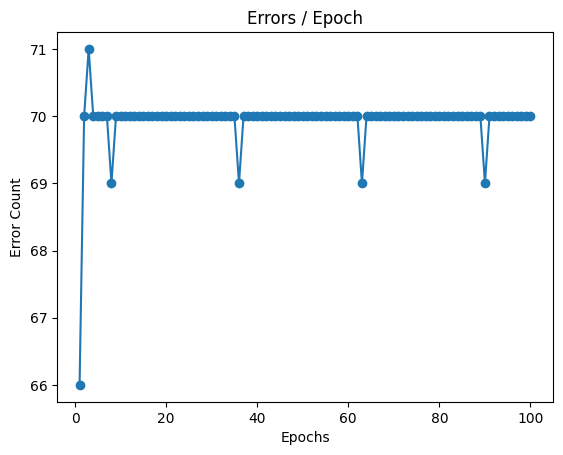

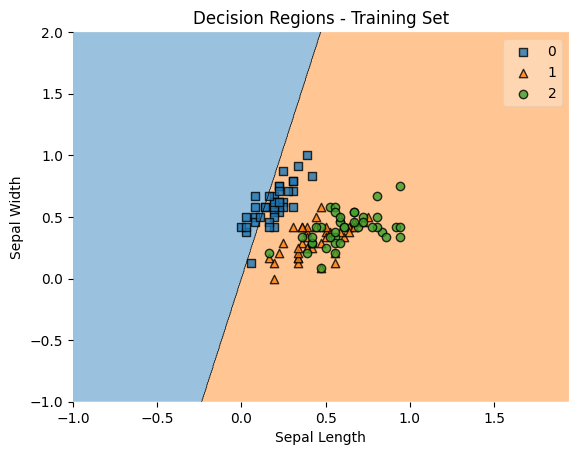

Train Accuracy: 0.4167
Train Precision: {0: 1.0, 1: 0.36936936936936937, 2: 0}
Train Recall: {0: 0.225, 1: 1.0, 2: 0.0}
Train F1 Score: {0: 0.36734693877551017, 1: 0.5394736842105263, 2: 0}
Test Accuracy: 0.3333
Test Precision: {0: 1.0, 1: 0.3103448275862069, 2: 0}
Test Recall: {0: 0.1, 1: 1.0, 2: 0.0}
Test F1 Score: {0: 0.18181818181818182, 1: 0.4736842105263158, 2: 0}


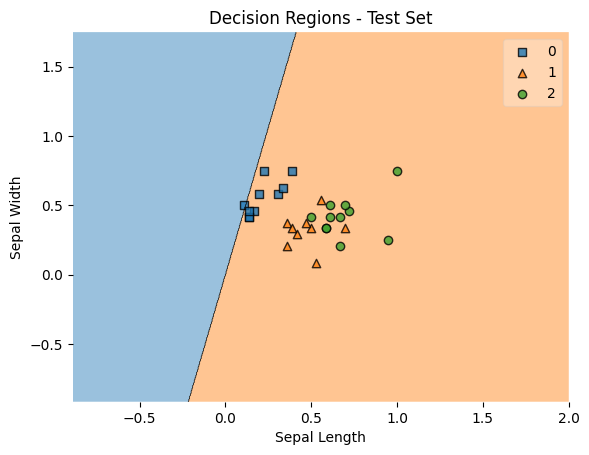

In [25]:
from mlxtend.plotting import plot_decision_regions
file_path = "C:\\Users\\smith\\OneDrive\\Desktop\\Machine Learning\\iris dataset.csv"
iris = pd.read_csv(file_path)
X = iris[[ 'sepal_length', 'sepal_width']]
y = iris['class']
X_norm = (X - X.min()) / (X.max() - X.min()) # Normalize features using min max
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) # Encode target variable using lib
data = pd.concat([X_norm, pd.DataFrame(y_encoded, columns=['class'])], axis=1) # Combine normalized features and encoded targets into a single df
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42) # Split data into train and test 

# Separate features and labels
X_train = train_df[[ 'sepal_length', 'sepal_width']].values
y_train = train_df['class'].values
X_test = test_df[[ 'sepal_length', 'sepal_width']].values
y_test = test_df['class'].values

class Perceptron(object):
    """Perceptron class"""

    def __init__(self, lr=0.1, epochs=50):
        self.lr = lr
        self.epochs = epochs

    def predict(self, X):
        return np.where(np.dot(X, self.w_) >= 0, 1, 0)

    def train(self, X, y): # Train func
        self.w_ = np.zeros(X.shape[1])
        self.errors = []
        for epoch in range(self.epochs):
            error_count = 0
            for xi, yi in zip(X, y):
                y_hat = self.predict(xi)
                update = self.lr * (yi - y_hat)
                self.w_ += update * xi
                error_count += int(update != 0.0)
            self.errors.append(error_count)
            if error_count == 0:
                break
        return self

    def plot_delta(self):
        plt.plot(range(1, len(self.errors) + 1), self.errors, marker='o')
        plt.title('Errors / Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Error Count')
        plt.show()

    def plot_dr(self, X, y, title):
        plot_decision_regions(X, y, clf=self)
        plt.title(title)
        plt.xlabel('Sepal Length')
        plt.ylabel('Sepal Width')
        plt.show()

def calculate_metrics(y_true, y_pred):
    classes = np.unique(y_true)
    TruePos = {cls: 0 for cls in classes}
    FalsePos = {cls: 0 for cls in classes}
    FalseNeg = {cls: 0 for cls in classes}
    TrueNeg = {cls: 0 for cls in classes}
    for true, pred in zip(y_true, y_pred): # Count number of TruePos, FalsePos, FalseNeg, and TrueNeg
        for cls in classes:
            if true == cls and pred == cls:
                TruePos[cls] += 1
            elif true != cls and pred == cls:
                FalsePos[cls] += 1
            elif true == cls and pred != cls:
                FalseNeg[cls] += 1
            elif true != cls and pred != cls:
                TrueNeg[cls] += 1
    # Calc accuracy, precision, recall, and f1 score
    accuracy = sum(TruePos.values()) / len(y_true)
    precision = {cls: TruePos[cls] / (TruePos[cls] + FalsePos[cls]) if (TruePos[cls] + FalsePos[cls]) > 0 else 0 for cls in classes}
    recall = {cls: TruePos[cls] / (TruePos[cls] + FalseNeg[cls]) if (TruePos[cls] + FalseNeg[cls]) > 0 else 0 for cls in classes}
    f1_score = {cls: 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if (precision[cls] + recall[cls]) > 0 else 0 for cls in classes}
    # Return values
    return accuracy, precision, recall, f1_score

# Train the Perceptron
ppn = Perceptron(epochs=100, lr=0.01)
ppn.train(X_train, y_train)
ppn.plot_delta()
ppn.plot_dr(X_train, y_train, title="Decision Regions - Training Set")

# Predict class labels for train and test
y_train_pred = ppn.predict(X_train)
y_test_pred = ppn.predict(X_test)
accuracy_train, precision_train, recall_train, f1_train = calculate_metrics(y_train, y_train_pred)
accuracy_test, precision_test, recall_test, f1_test = calculate_metrics(y_test, y_test_pred) # Calculate metrics for the train and test sets

# Print metrics
print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")

# Plot decision regions for test set
ppn.plot_dr(X_test, y_test, title="Decision Regions - Test Set")


Comparison and Analysis


Explanation of each algorithm:

Gaussian Discriminant Analysis (GDA): GDA is a generative machine learning model. Its basis is assuming that the data follows a normal distributionn also called Gaussian distribution. It leverages probability theory for classificaiton models by modeling joint probability of features and class labels. It also uses prior probability which is the likelihood of class. Finally using Bayes theorem GDA models calculate posterior probability which is used for classification. GDA is a useful modeling technique; however, that does not mean it has limitations which we will examine later.

Logistic Regression Gradient Descent: logistic regression unlike linear regression does not deal with continuous values rather specific classes. Also instead of using MSE logistic regression use a cost function aka log loss to measure actual vs predicted. It classifies by predicting a threshold then if it is more than or equal it is classified as postive class. Otherwise, if it is less than that threshold it is classified as negative. The gradient works by initializing weights randomly then calculate and measure the classification results. Then using N iterations it keeps going until convergence or a certain error threshold is met.

Perceptron: perceptron is a learning classification algorithm that is very useful for linearly seperable data. Perceptron is an algorithm that has withstood the test of time and is widely known and used. It is also the building blocks of some neural networks. The way it works is by initializing weights, setting a bias, then chooisng a learning rate, and number of epochs. Then uses the calculation of weighted sum and activates the function and iteratively updates weight and bias until it finds an acceptable error level. 

Comparison of the performance between GDA, Logistic Regression, and Perceptron using appropriate accuracy, precision, recall, and f1 score:
Logistic Regression and GDA performed similarly with Logistic regression having a higher training accuracy but they had the same testing accuracy which is important becuase it means they were accurately predicting after train. I think that all models would have performed similar if i got perceptron to predict more accurately. It did not seem to predict a decision boundary very accurately even though the data seemed linearly seperable. On that condition I think it is possible that they would have all predicted very well. However, in the case of my implementation Logistic Regression performed the best in terms of accuracy, precision, recall, and f1 score.
GDA:
Train Accuracy: 0.7750
Train Precision: {0: 1.0, 1: 0.6590909090909091, 2: 0.6756756756756757}
Train Recall: {0: 0.975, 1: 0.7073170731707317, 2: 0.6410256410256411}
Train F1 Score: {0: 0.9873417721518987, 1: 0.6823529411764706, 2: 0.6578947368421052}
Test Accuracy: 0.9000
Test Precision: {0: 1.0, 1: 0.875, 2: 0.8333333333333334}
Test Recall: {0: 1.0, 1: 0.7777777777777778, 2: 0.9090909090909091}
Test F1 Score: {0: 1.0, 1: 0.823529411764706, 2: 0.8695652173913043}

Logistic Regression:
Train Accuracy: 0.8500
Train Precision: 0.9259259259259259
Train Recall: 0.6097560975609756
Train F1 Score: 0.7352941176470589
Test Accuracy: 0.9000
Test Precision: 1.0
Test Recall: 0.6666666666666666
Test F1 Score: 0.8

Perceptron: 
Train Accuracy: 0.4167
Train Precision: {0: 1.0, 1: 0.36936936936936937, 2: 0}
Train Recall: {0: 0.225, 1: 1.0, 2: 0.0}
Train F1 Score: {0: 0.36734693877551017, 1: 0.5394736842105263, 2: 0}
Test Accuracy: 0.3333
Test Precision: {0: 1.0, 1: 0.3103448275862069, 2: 0}
Test Recall: {0: 0.1, 1: 1.0, 2: 0.0}
Test F1 Score: {0: 0.18181818181818182, 1: 0.4736842105263158, 2: 0}
Analyzation of strenghts and weaknesses of each algorithm:
GDA handles multiclass data very well but a weakness would be it assumes Gaussian distribution which we know in many datasets is not the case. It can also be very good with smaller datasets but not so with larger ones. Perceptron is very well known and considered the backbone of many neural networks and applications. It is very efficient for linearly seperable data as well. However it is worth noting that it is sensitive to the parameters of learning rate and epochs. Lastly, Logistic regression with gradient descent is efficient and handles multiclass well with applying one v all approach, but falls short when dealing with large outliers.